# Rによるステップワイズ回帰

## R概論

- Rはオープンソース・無料の統計解析用プログラミング言語及びソフトウェアである。統計処理が少ない行数で簡潔に行えるように作られている。
- 新しいモデリング手法が論文で提案されるタイミングで、一緒にRライブラリが実装されることもあり、最先端な手法を実装した先進的ライブラリも多い。
- Rはソフトウェアとして捉えた方が良い。Rは素早くデータを確認し、モデルを試して評価し、レポートを作成するには最適で、処理内容によってはPythonよりも容易に素早く作業を完了することができるが、__一般にシステムにRを組み込むことは、Pythonと比べて難しい__。すなわち、あまり実装向きではない。
    - 他方、Pythonは汎用プログラミング言語であり、容易にウェブシステム、社内システム等に組み込むことができる。これがAmazon、Facebookなどの実装が重視されるデータサイエンスチームでよくPythonが採用される理由である。
    - 一方で、アカデミックの世界や、実装よりもレポーティングが重視される医療統計/生物統計では、Rの方が人気がある分野も多い。
- R単体には、Pythonの仮想環境(conda, pyenv等)のように"環境を分ける機能"は実装されていない。
- R言語そのものは高速な言語ではないが、RもPython同様、裏側でCやFortran関数を呼んでおり、結果高速な数値計算が可能である。

## インストール

Rのインストールであるが、以下の手順で行う。__condaからインストールする方法もあるが、ライブラリ管理が面倒なので推奨しない__

1. [こちら](https://cran.r-project.org/bin/macosx/)からインストールパッケージ(R3.6.1.pkg)をダウンロード、インストール。
2. ターミナルで`r`と打って、rを起動。
3. `install.packages(c(‘repr’, ‘IRdisplay’, ‘evaluate’, ‘crayon’, ‘pbdZMQ’, ‘devtools’, ‘uuid’, ‘digest’), repos="https://cran.ism.ac.jp/")`
    - c()で"ベクトル"を作成できる。Pythonでいうところのnp.arrayに近いか。データは全て同じデータ型にキャストされる。
    - reposキーワード引数で、どのミラーサーバーからインストールするかを指定できる。基本、日本のサーバーを指定しておけばOK。
4. `devtools::install_github(‘IRkernel/IRkernel’)`
    - このコマンドは、devtoolsライブラリのinstall_github関数を使いますよ、という意味。
    - install_github関数はgithubのレポジトリ文字列を引数にもち、そのレポジトリからrライブラリをインストールできる。(もちろん、rライブラリ用に作られたレポジトリ限定だが)
5. jupyterから、新規notebookを作成する際に、Rというカーネルを選択できるようになる。

パッケージのインストールは、ターミナルからrを起動し、`install.packages("パッケージ名")`でインストールできる。  
例えばRODBCをインストールしたい場合は、`install.packages("RODBC", repos="https://cran.ism.ac.jp/")`

## 最低限の基本

In [6]:
# ベクトルの例
c(1, 2, 3)

[1] 1 2 3

In [7]:
# 文字列を含めると、勝手に文字列型に統一される
c(1, 2, "3")

[1] "1" "2" "3"

In [22]:
# 普通の計算はpythonと同様だが、整数商と余りのみ、記法が異なる。print()で中身を表示。
print(1 * 2 * 3)
print(1 + 2)
print(3/ 4)
print(3 ** 2)
print(10 %/% 3) # 整数の商
print(10 %% 3) # 余り

[1] 6
[1] 3
[1] 0.75
[1] 9
[1] 3
[1] 1


In [23]:
# 文字列は""でも''でも良い。Pythonと同じ
c("a", 'b')

[1] "a" "b"

In [25]:
# 変数への代入は左矢印を使用する。=でも可能だが、左矢印が推奨である。
a <- 1
print(a)

[1] 1


## DBへの接続

事前にターミナルからrを起動し、`install.packages("RODBC", repos="https://cran.ism.ac.jp/")`を実行しておく。

次に、ODBCのDSN(Data Source Name)を作成する。まず、ターミナルで`sudo chmod 773 ~/Library/ODBC/odbc.ini`と打って、グループユーザーで実行できるようにしておく。

まだTeradataのODBCDriverをインストールしていない場合は、インストールしておく。ファイルは[ここ](https://downloads.teradata.com/download/connectivity/teradata-odbc-driver-for-mac-os-x)から入手できる。(要ユーザー登録)

次にLaunchpadからodbcと検索して、ODBC Administratorを起動。UserDNSタブで、左下の鍵マークを外してから、Addをクリック。  
以下のように、名前、IP Address、Username、デフォルトデータベース、文字コードを設定。OKを押す。Applyを押して登録完了。

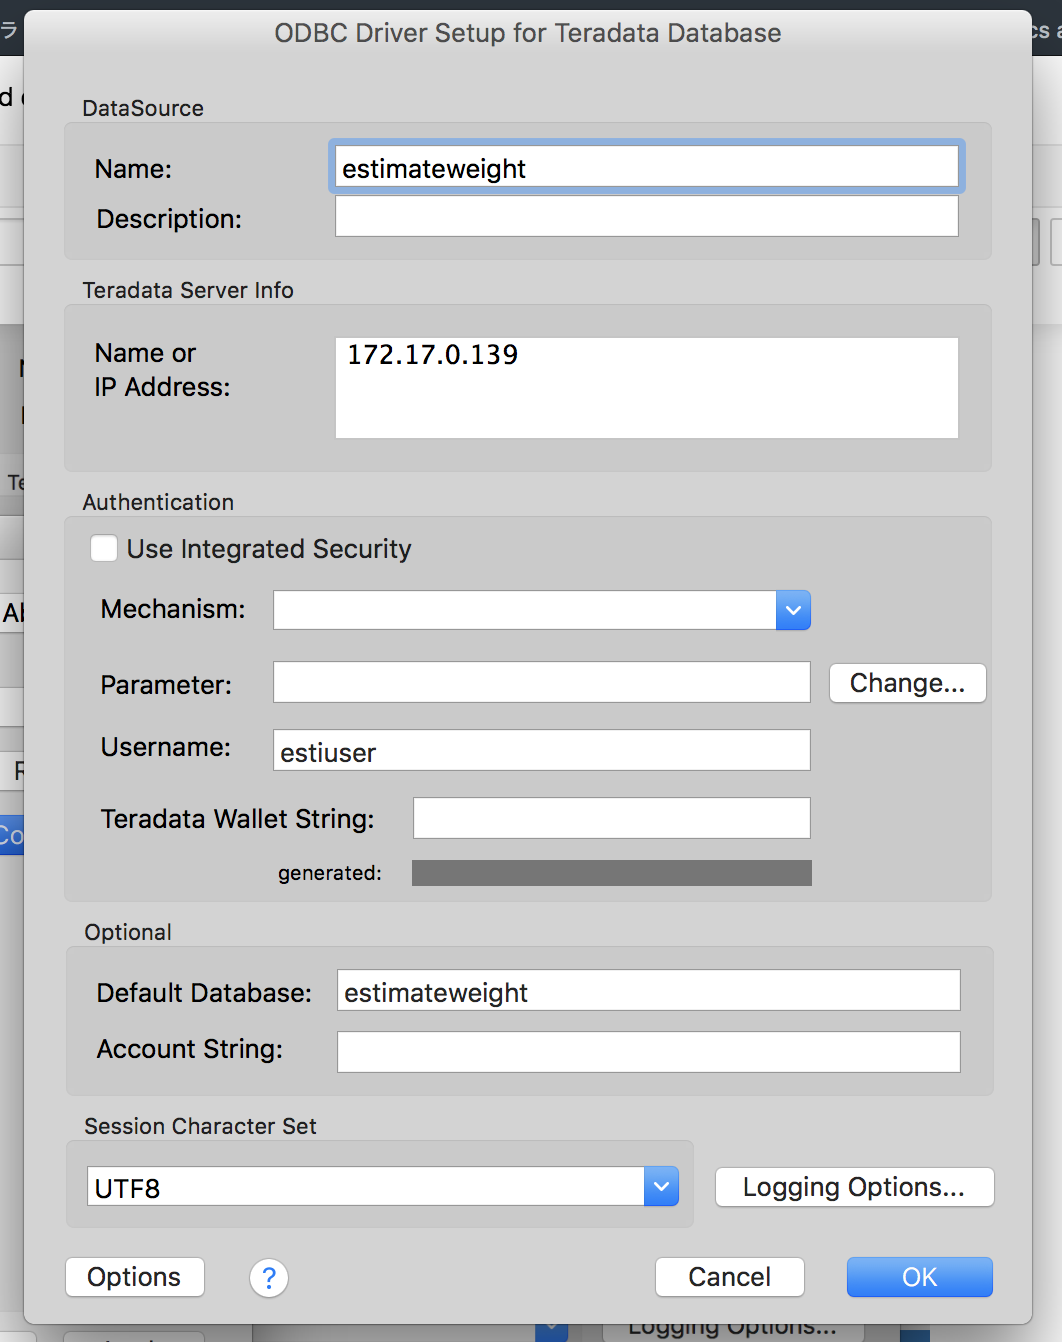

In [39]:
library("IRdisplay")
display_png(file="odbc.png", width=500)

In [26]:
library(RODBC) # ライブラリの読み込みはlibrary(パッケージ名)

In [27]:
# 接続オブジェクトを作成
con <- odbcConnect(dsn = "estimateweight",  uid = "estiuser",  pwd = "estiuser")

In [28]:
# このようにクエリを投げることができる。大きなテーブルが返ってくる場合はtop ~~を忘れないこと！
sqlQuery(con, "select top 5 * from TBL_12_HASH_SEPARATE;")

starttime_no,time0,hash_separate
<int>,<dbl>,<int>
157,12,0
119,4,1
408,34,0
210,48,2
472,49,0


## 線形回帰

In [40]:
# Rには標準組み込みデータセットがあり、すぐに使用できる
df_iris <- iris

In [41]:
str(df_iris) # strで変数の中身を見ることができる。(stringではなくstructureの略)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


data.frame型のデータで、レコード数は150、5つの変数が含まれている。  
Sepal.Length ~ Petal.Width列はnum(numeric)型、SpeciesはFactor型であり、3つの種類がある。最初のデータ10個も眺めることができる。

numericは実数を、Factorはカテゴリを格納するのに使用される。

pandasのDataFrameは、Rのdata.frame型をPythonで再現したものである。(pandasの作成者は、pandasを作成するまではRを使用していた。)

In [46]:
# 各列にはpandas的にアクセスできる
head(df_iris["Sepal.Length"]) # headはRではメソッドではなく関数になっている。

Sepal.Length
<dbl>
5.1
4.9
4.7
4.6
5.0
5.4


In [57]:
dim(df_iris) # pandasでいうところのshapeメソッドは、dim関数

[1] 150   5

In [59]:
nrow(df_iris) # 行数はnrow

[1] 150

線形回帰は、R独特の記法を用いて行う。

In [61]:
# df_irisテーブルのSepal.Length列を、Sepal.Widthと切片(1)を使用して回帰する。
model <- lm(Sepal.Length ~ Sepal.Width + 1, df_iris)

In [62]:
summary(model) # 回帰結果を見る


Call:
lm(formula = Sepal.Length ~ Sepal.Width + 1, data = df_iris)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5561 -0.6333 -0.1120  0.5579  2.2226 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.5262     0.4789   13.63   <2e-16 ***
Sepal.Width  -0.2234     0.1551   -1.44    0.152    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8251 on 148 degrees of freedom
Multiple R-squared:  0.01382,	Adjusted R-squared:  0.007159 
F-statistic: 2.074 on 1 and 148 DF,  p-value: 0.1519


結果からは、Sepal.Widthは説明変数としてはイマイチなことがわかる。  
(詳細は省くが、t value(t値)が1.44と、-2または2を超えておらず、関係性が統計的に有意でない)  

In [63]:
# 多変量でも回帰してみる
model <- lm(Sepal.Length ~ Sepal.Width + Petal.Length + Petal.Width + 1, df_iris)

In [64]:
summary(model)


Call:
lm(formula = Sepal.Length ~ Sepal.Width + Petal.Length + Petal.Width + 
    1, data = df_iris)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82816 -0.21989  0.01875  0.19709  0.84570 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.85600    0.25078   7.401 9.85e-12 ***
Sepal.Width   0.65084    0.06665   9.765  < 2e-16 ***
Petal.Length  0.70913    0.05672  12.502  < 2e-16 ***
Petal.Width  -0.55648    0.12755  -4.363 2.41e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3145 on 146 degrees of freedom
Multiple R-squared:  0.8586,	Adjusted R-squared:  0.8557 
F-statistic: 295.5 on 3 and 146 DF,  p-value: < 2.2e-16


今度はどの変数も有意に相関しているという結果となった。(もっとも、これは実は多重線形性が出てしまっており、全ての変数が強く予測に寄与しているわけではないのだが...)

ちなみに、定数のみで回帰する(横線だけで回帰する)場合は、1のみを説明変数に加える

In [65]:
model <- lm(Sepal.Length ~ 1, df_iris)
summary(model)


Call:
lm(formula = Sepal.Length ~ 1, data = df_iris)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.54333 -0.74333 -0.04333  0.55667  2.05667 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.84333    0.06761   86.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8281 on 149 degrees of freedom


定数でSepal.Lengthを回帰する場合は、5.84という定数で回帰するのが最も誤差(二乗誤差)が小さいようだ。

## ステップワイズ

Rは解析ソフトウェアの名に恥じず、分析関数はだいたい揃っている。ステップワイズも関数がある。  
(もっとも、Pythonでも十数行で書けるが...)

使い方は、```
step(
    開始時のモデル, 
    direction=ステップワイズの方向, 
    scope=list(upper=最も変数をたくさん含むモデル, 
    lower=最も変数を含まないモデル)), 
    k=ペナルティの掛け目
    )
```

rのlistはPythonのリストに近く、どんなデータ型でも入れることができる。入れ子構造もOKである。

step関数の詳細は[こちら](https://www.rdocumentation.org/packages/stats/versions/3.6.1/topics/step)

- 開始時のモデルは、ステップワイズを開始するときにモデルである。基本的には、定数のみで回帰したモデルになるだろう。  
- ステップワイズの方向は、"forward", "backward","both"から選べる。bothは毎回変数を減らす/増やすどちらも検討する。  
- ペナルティの掛け目は、AICなら2、BICならlog(データ数)である。  
$$AIC = -2ln(尤度) + 2 \cdot (パラメータ数)$$
$$BIC = -2ln(尤度) + ln(データ数) \cdot (パラメータ数)$$

- scopeでは、upperとlowerを両方指定できるが、forwardではupper、backwardではlowerのみ指定すれば十分である。

In [68]:
# Spepal.Lengthをステップワイズ
m_stepwise <- step(object=lm(Sepal.Length ~ 1, df_iris), 
                   scope=list(upper = Sepal.Length ~ Sepal.Width + Petal.Width + Petal.Length + 1
                             ,lower= Sepal.Length ~ 1),
                   k = log(nrow(df_iris)),
                   direction="forward"
                   )

Start:  AIC=-52.59
Sepal.Length ~ 1

               Df Sum of Sq     RSS      AIC
+ Petal.Length  1    77.643  24.525 -261.620
+ Petal.Width   1    68.353  33.815 -213.439
<none>                      102.168  -52.591
+ Sepal.Width   1     1.412 100.756  -49.669

Step:  AIC=-261.62
Sepal.Length ~ Petal.Length

              Df Sum of Sq    RSS     AIC
+ Sepal.Width  1    8.1963 16.329 -317.62
<none>                     24.525 -261.62
+ Petal.Width  1    0.6443 23.881 -260.60

Step:  AIC=-317.62
Sepal.Length ~ Petal.Length + Sepal.Width

              Df Sum of Sq    RSS     AIC
+ Petal.Width  1    1.8834 14.445 -331.00
<none>                     16.329 -317.62

Step:  AIC=-331
Sepal.Length ~ Petal.Length + Sepal.Width + Petal.Width



最終的に、全ての変数が追加された。

In [71]:
# summaryで最終モデルをチェックできる
summary(m_stepwise)


Call:
lm(formula = Sepal.Length ~ Petal.Length + Sepal.Width + Petal.Width, 
    data = df_iris)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.82816 -0.21989  0.01875  0.19709  0.84570 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.85600    0.25078   7.401 9.85e-12 ***
Petal.Length  0.70913    0.05672  12.502  < 2e-16 ***
Sepal.Width   0.65084    0.06665   9.765  < 2e-16 ***
Petal.Width  -0.55648    0.12755  -4.363 2.41e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3145 on 146 degrees of freedom
Multiple R-squared:  0.8586,	Adjusted R-squared:  0.8557 
F-statistic: 295.5 on 3 and 146 DF,  p-value: < 2.2e-16


In [69]:
# 両方向でも行ってみる
m_stepwise <- step(object=lm(Sepal.Length ~ 1, df_iris), 
                   scope=list(upper = Sepal.Length ~ Sepal.Width + Petal.Width + Petal.Length + 1
                             ,lower= Sepal.Length ~ 1),
                   k = log(nrow(df_iris)),
                   direction="both"
                   )

Start:  AIC=-52.59
Sepal.Length ~ 1

               Df Sum of Sq     RSS      AIC
+ Petal.Length  1    77.643  24.525 -261.620
+ Petal.Width   1    68.353  33.815 -213.439
<none>                      102.168  -52.591
+ Sepal.Width   1     1.412 100.756  -49.669

Step:  AIC=-261.62
Sepal.Length ~ Petal.Length

               Df Sum of Sq     RSS     AIC
+ Sepal.Width   1     8.196  16.329 -317.62
<none>                       24.525 -261.62
+ Petal.Width   1     0.644  23.881 -260.60
- Petal.Length  1    77.643 102.168  -52.59

Step:  AIC=-317.62
Sepal.Length ~ Petal.Length + Sepal.Width

               Df Sum of Sq     RSS     AIC
+ Petal.Width   1     1.883  14.445 -331.00
<none>                       16.329 -317.62
- Sepal.Width   1     8.196  24.525 -261.62
- Petal.Length  1    84.427 100.756  -49.67

Step:  AIC=-331
Sepal.Length ~ Petal.Length + Sepal.Width + Petal.Width

               Df Sum of Sq    RSS     AIC
<none>                      14.445 -331.00
- Petal.Width   1    1.883

結果は同じ